In [1]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras import backend as K

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# For the recurrent UNET, we need to incorporate saliency priors into X_train. Also add a list of T ground truths 
# as the y_train. Here T =3. (you may need to modify this and the above cell with your path to the two files)

X = np.load('/content/drive/My Drive/Saliency Detection data/X_UNET_recurr_prior_map.npy')
y = np.load('/content/drive/My Drive/Saliency Detection data/y_UNET_recurr_prior_map.npy')

In [4]:
print(X.shape)
print(y.shape)

(1928, 224, 224, 4)
(1928, 3, 224, 224, 1)


In [ ]:
# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(1735, 224, 224, 4)
(1735, 3, 224, 224, 1)


In [ ]:
im_width = 224
im_height = 224
im_depth = 4

# Block of two convolutional layers
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):

    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), \
               kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), \
               kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def get_unet_recurrent(input_img_recurr, T, n_filters=16, dropout=0.1, batchnorm=True):

    # Writing the tensor dimensions just for clarity
    # Extract the RGB image. This will not change over each time step
    input_img = input_img_recurr[:, :, :, 0:3] # (None, 224, 224, 3)
    #print(K.int_shape(input_img))

    # This will be updated by the latest prediction at the end of each time step. Initialized to the saliency prior map. 
    rec_outputs = input_img_recurr[:, :, :, 3] # (None, 224, 224)
    rec_outputs = tf.expand_dims(rec_outputs, axis=3) # (None, 224, 224, 1)
    #print(K.int_shape(rec_outputs))

    # Define the base U-net model

    # Contracting Path
    c1 = conv2d_block(input_img_recurr, n_filters * 4, kernel_size=3, batchnorm=batchnorm) # 224x224
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 8, kernel_size=3, batchnorm=batchnorm) # 112x112
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 16, kernel_size=3, batchnorm=batchnorm) # 56x56
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 32, kernel_size=3, batchnorm=batchnorm) # 28x28
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters * 64, kernel_size=3, batchnorm=batchnorm) # 14x14

      # Expansive Path
    u6 = Conv2DTranspose(n_filters * 32, (3, 3), strides=(2, 2), padding='same')(c5) # 14x14
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 32, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters * 16, (3, 3), strides=(2, 2), padding='same')(c6) # 28x28
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 16, kernel_size=3, batchnorm=batchnorm) # 56x56

    u8 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(c7) # 112x112
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 8, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c8) # 224x224
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 4, kernel_size=3, batchnorm=batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9) # (None, 224, 224, 1)
    #print(K.int_shape(outputs))

    model = Model(inputs=[input_img_recurr], outputs=[outputs])

    # List of output tensors to store the output at every time step t.
    output_list = []

    # Now create the recurrent model

    for t in range(T):
      rec_outputs = model(concatenate([input_img, rec_outputs])) # (None, 224, 224, 1)
      rec_exp_out = tf.expand_dims(rec_outputs, axis=1) # (None, 1, 224, 224, 1)
      # print(K.int_shape(rec_exp_out))
      output_list.append(rec_exp_out)
    
    out_list = tf.concat(output_list, axis = 1) # (None, 3, 224, 224, 1)
    # print(K.int_shape(out_list))

    recur_model = Model(inputs=[input_img_recurr], outputs = [out_list])

    return recur_model

In [ ]:
input_img_recurr = Input((im_height, im_width, im_depth), name='img_recur')
print(K.int_shape(input_img_recurr))
test_img = input_img_recurr[:, :, :, 3]
test_img_exp = tf.expand_dims(test_img, axis = 3)
print(K.int_shape(test_img_exp))

(None, 224, 224, 4)
(None, 224, 224, 1)


In [ ]:
# Initialize input tensor and U-net. Also set number of recurrent time steps
T = 3

input_img_recurr = Input((im_height, im_width, im_depth), name='img_recur')
recur_model = get_unet_recurrent(input_img_recurr, T, n_filters=16, dropout=0.05, batchnorm=True)


In [ ]:
recur_model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

print(recur_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_recur (InputLayer)          [(None, 224, 224, 4) 0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_5 (Te [(None, 224, 224)]   0           img_recur[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_strided_slice_4 (Te [(None, 224, 224, 3) 0           img_recur[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_6 (Tenso [(None, 224, 224, 1) 0           tf_op_layer_strided_slice_5[0][0]
____________________________________________________________________________________________

In [ ]:


callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-UNET_recur_sal_prior.h5', verbose=1, save_best_only=True, save_weights_only=True)
]



results = recur_model.fit(X_train, y_train, batch_size=10, epochs=50, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 1735 samples, validate on 193 samples
Epoch 1/50
1730/1735 [============================>.] - ETA: 0s - loss: 0.5198 - acc: 0.7323
Epoch 00001: val_loss improved from inf to 0.49175, saving model to model-UNET_recur_sal_prior.h5
1735/1735 [==============================] - 126s 73ms/sample - loss: 0.5201 - acc: 0.7322 - val_loss: 0.4917 - val_acc: 0.7502
Epoch 2/50
1730/1735 [============================>.] - ETA: 0s - loss: 0.4790 - acc: 0.7621
Epoch 00002: val_loss improved from 0.49175 to 0.48355, saving model to model-UNET_recur_sal_prior.h5
1735/1735 [==============================] - 120s 69ms/sample - loss: 0.4799 - acc: 0.7615 - val_loss: 0.4835 - val_acc: 0.7635
Epoch 3/50
1730/1735 [============================>.] - ETA: 0s - loss: 0.4664 - acc: 0.7732
Epoch 00003: val_loss improved from 0.48355 to 0.47057, saving model to model-UNET_recur_sal_prior.h5
1735/1735 [==============================] - 120s 69ms/sample - loss: 0.4660 - acc: 0.7734 - val_loss: 0.4706 - val_

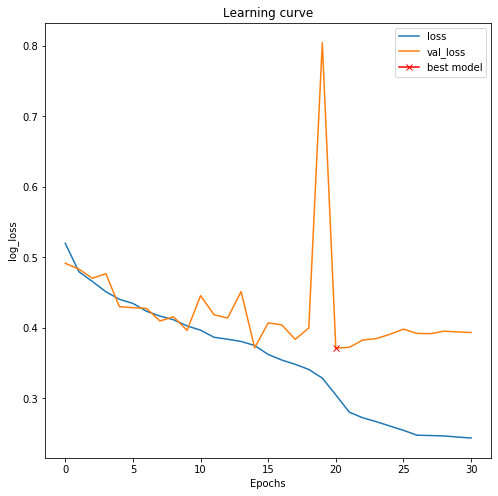

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.show()

In [ ]:
# Inference

# Load the best model
recur_model.load_weights('model-UNET_recur_sal_prior.h5')

# Evaluate on training set
recur_model.evaluate(X_train, y_train, verbose=1)

# Evaluate on validation set
recur_model.evaluate(X_valid, y_valid, verbose=1)

# Predict on train, val and test
preds_train = recur_model.predict(X_train, verbose=1)
preds_val = recur_model.predict(X_valid, verbose=1)

print(preds_train.shape)
print(preds_val.shape)

# # Threshold predictions
# preds_train_t = (preds_train > 0.5).astype(np.uint8)
# preds_val_t = (preds_val > 0.5).astype(np.uint8)

193/193 [==============================] - 3s 15ms/sample
(1735, 3, 224, 224, 1)
(193, 3, 224, 224, 1)


In [ ]:
# Check if data looks alright
def plot_sample(X, y, preds, ix=0):

    for i in range(ix):
        i_rand = np.random.randint(0, len(X))

        fig,ax = plt.subplots(1, T+2)

        ax[0] = plt.subplot(1, T + 3, 1)
        ax[0].imshow(X[i_rand,  :, :, :3])
        ax[0].set_title('Orig. Img.')

        ax[1] = plt.subplot(1, T + 3, 2)
        ax[1].imshow(y[i_rand, 0,  :, :, 0], 'gray')
        ax[1].set_title('GT')

        ax[1] = plt.subplot(1, T+3, 3)
        ax[1].imshow(X[i_rand, :, : , 3], 'gray')
        ax[1].set_title('Sal. Prior')

        for t in range(T):
          ax[t+2] = plt.subplot(1, T+3, t+4)
          ax[t+2].imshow(preds[i_rand, t, :, :, 0], 'gray')
          title_t = 'at t = ' + str(t+1)
          ax[t+2].set_title(title_t)



        plt.show()

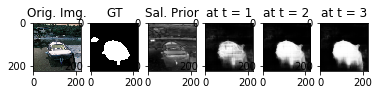

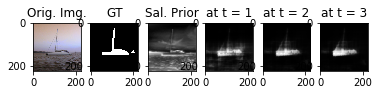

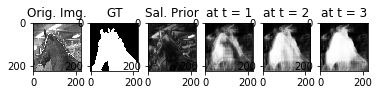

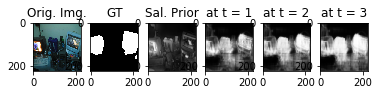

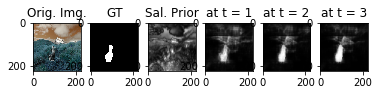

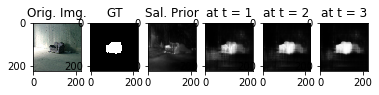

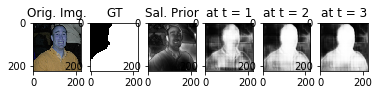

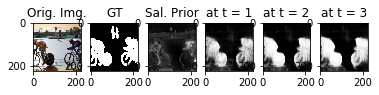

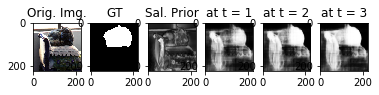

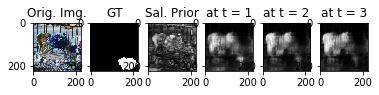

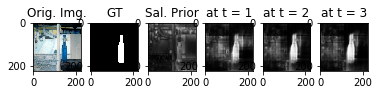

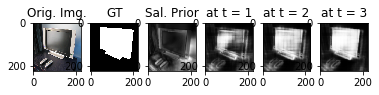

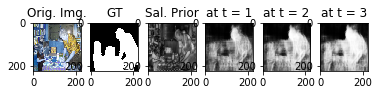

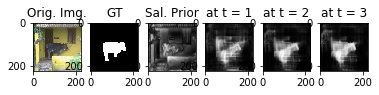

In [ ]:
# Check if training data looks alright
plot_sample(X_train, y_train, preds_train, ix=14)

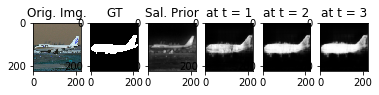

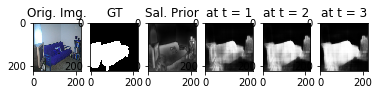

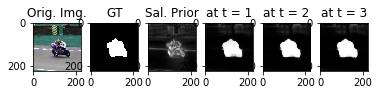

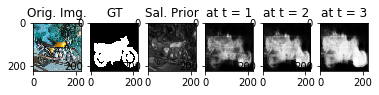

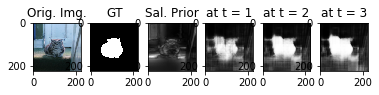

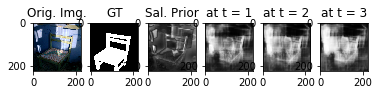

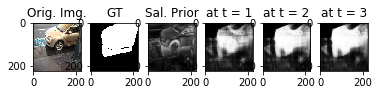

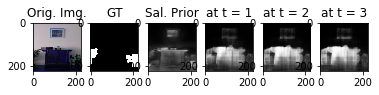

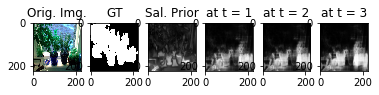

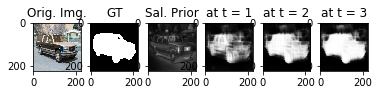

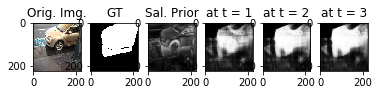

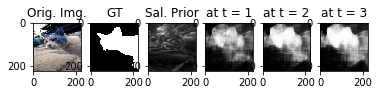

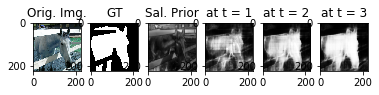

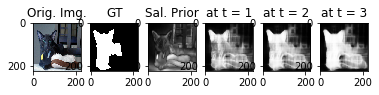

In [ ]:
# Check if valid data looks alright
plot_sample(X_valid, y_valid, preds_val, ix=14)